In [4]:
import cv2
from PIL import Image, ImageOps
import os
import git
import numpy as np
import pandas as pd
import pickle
import glob
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import subprocess
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tune_sklearn import TuneSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import randint
import numpy as np
import shutil
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [7]:
def make_dataset(size=28):
    repo_url = "https://github.com/pongsapaks/Thai-handwrittingnumberproject.git"
    repo_dir = "Thai-handwrittingnumberproject"
    subprocess.run(["git", "clone", repo_url, repo_dir])

    image_dir = os.path.join(repo_dir, "raw")

    # Fetch all image files within the directory and its subfolders
    image_files = []
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.endswith(".png"):  # Remove the double asterisks
                image_files.append(os.path.join(root, file))

    print("Total image files:", len(image_files))  # Added for debugging purposes

    X = []
    Y = []
    for image_path in image_files:
        img = cv2.imread(image_path)
        img = Image.open(image_path).convert("L")  # Use image_path instead of file
        img = ImageOps.invert(img)  # Invert the image
        img = img.resize((size, size))  # Resize the image
        label = os.path.basename(os.path.dirname(image_path))
        x = np.array(img)
        X.append(x)
        Y.append(label)

    X = np.asarray(X)
    Y = np.asarray(Y)
    data = {"X": X, "Y": Y}
    pickle.dump(data, open(f"thainumber_{size}.pkl", "wb"), protocol=2)

    ## make_df
    reshaped_X = X.reshape((X.shape[0], -1))
    reshaped_X.shape
    Ydf = pd.DataFrame(Y)
    Xdf = pd.DataFrame(reshaped_X)

    # Standardization
    X_mean = Xdf.mean()
    X_std = Xdf.std()
    Z = (Xdf - X_mean) / X_std
    Z = Z.fillna(0)

    # Apply PCA
    pca = PCA(n_components=0.75)
    pca.fit(Z)
    X_pca = pca.transform(Z)

    # Train model
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, Y, test_size=0.2, random_state=42
    )

    # Check PCA
    n_s = np.linspace(0.70, 0.85, num=16)
    for n in n_s:
        pca = PCA(n_components=n)
        pca.fit(Z)
        X_pca = pca.transform(Z)

        X_train, X_test, y_train, y_test = train_test_split(
            X_pca, Y, test_size=0.2, random_state=42
        )

        sv = SVC(C=10, gamma=0.001, kernel='rbf')
        sv.fit(X_train, y_train)

        pred = sv.predict(X_test)
        correct = 0
        for i in range(len(y_test)):
            if pred[i] == y_test[i]:
                correct += 1

    sv = SVC(C=10, gamma=0.001, kernel='rbf')
    sv.fit(X_train, y_train)

    pred = sv.predict(X_test)
    correct = 0
    for i in range(len(y_test)):
        if pred[i] == y_test[i]:
            correct += 1
    ##print("Accuracy:", correct / len(pred))
    y_pred_sv = sv.predict(X_test)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_sv)

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot the confusion matrix using a heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)

    # Set labels, title, and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.yticks(rotation=0)

    # Display the plot
    plt.show()

Total image files: 1795


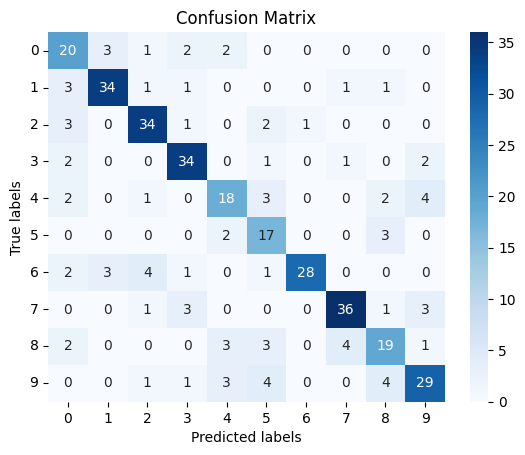

In [8]:
make_dataset(size=28)